# Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import requests
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
url = "https://drive.google.com/uc?id=1NWGtC7o6aHnvcPhfkfesP8bpRtksrewL"
dataset_file = "stunting_wasting_dataset.csv"
response = requests.get(url)
with open(dataset_file, "wb") as f:
    f.write(response.content)

In [3]:
data = pd.read_csv(dataset_file)
data

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight
...,...,...,...,...,...,...
99995,Laki-laki,11,75.3,7.3,Normal,Underweight
99996,Laki-laki,21,93.7,14.8,Normal,Risk of Overweight
99997,Perempuan,18,82.9,12.6,Normal,Risk of Overweight
99998,Laki-laki,7,73.6,5.5,Normal,Severely Underweight


In [4]:
print("Informasi Dataset:")
display(data.info())
print("\nJumlah Missing Values:")
display(data.isnull().sum())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


None


Jumlah Missing Values:


,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [5]:
data = data.dropna()
if 'Stunting' in data.columns:
    print("\nDistribusi Kolom 'Stunting':")
    print(data['Stunting'].value_counts())
else:
    raise ValueError("Kolom 'Stunting' tidak ditemukan dalam dataset.")


Distribusi Kolom 'Stunting':
Stunting
Normal              72312
Stunted             16160
Severely Stunted     5819
Tall                 5709
Name: count, dtype: int64


<ipython-input-6-4a0ce18af774>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Stunting', data=data, palette='pastel')


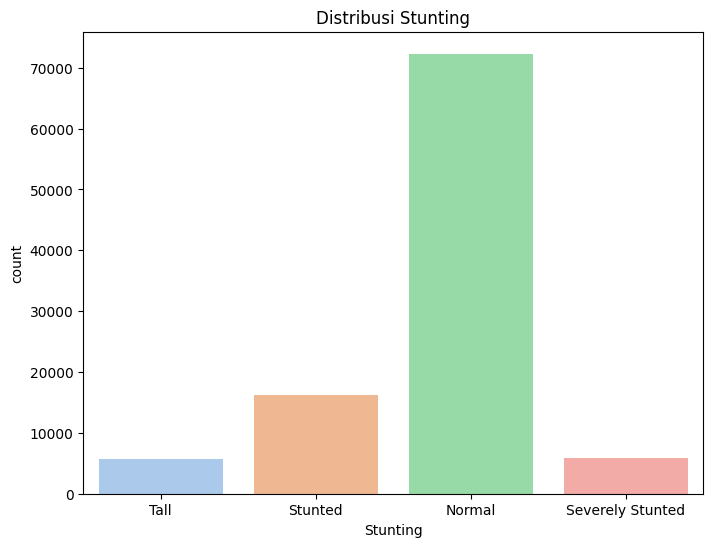

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Stunting', data=data, palette='pastel')
plt.title('Distribusi Stunting')
plt.show()

In [7]:
X = data.drop('Stunting', axis=1)
y = data['Stunting']

In [8]:
X = pd.get_dummies(X, drop_first=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
if len(y_train.unique()) > 2:
    encoder = OneHotEncoder(sparse_output=False)
    y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
    y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))
else:
    y_train_encoded = y_train
    y_test_encoded = y_test

In [14]:
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1 if len(y_train.unique()) == 2 else len(y_train.unique()),
          activation='sigmoid' if len(y_train.unique()) == 2 else 'softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy' if len(y_train.unique()) == 2 else 'categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [17]:
history = model.fit(X_train_scaled, y_train_encoded,
                    validation_data=(X_test_scaled, y_test_encoded),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.7893 - loss: 0.5580 - val_accuracy: 0.9172 - val_loss: 0.2241
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8825 - loss: 0.2641 - val_accuracy: 0.9368 - val_loss: 0.1682
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9021 - loss: 0.2227 - val_accuracy: 0.9414 - val_loss: 0.1470
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9143 - loss: 0.1963 - val_accuracy: 0.9492 - val_loss: 0.1309
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9219 - loss: 0.1804 - val_accuracy: 0.9494 - val_loss: 0.1270
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9248 - loss: 0.1740 - val_accuracy: 0.9524 - val_loss: 0.1181
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9294 - loss: 0.1612 - val_accuracy: 0.9518 - val_loss: 0.1121
Epoch 8/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9305 - loss

In [18]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.2f}")


Test Accuracy: 0.98


In [23]:
class_labels = ["Normal", "Stunted", "Severely Stunted", "Tall"]

label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

y_pred = model.predict(X_test_scaled)
y_pred_classes = y_pred.argmax(axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

if len(y_test_encoded.shape) > 1:
    y_test_classes = y_test_encoded.argmax(axis=1)
else:
    y_test_classes = y_test_encoded

y_test_labels = label_encoder.inverse_transform(y_test_classes)

print("\nFeedforward Neural Network (FNN) Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Feedforward Neural Network (FNN) Classification Report:
                  precision    recall  f1-score   support

          Normal       0.99      0.99      0.99     14406
Severely Stunted       0.94      0.93      0.93      1146
         Stunted       0.95      0.96      0.95      3292
            Tall       0.96      0.89      0.92      1156

        accuracy                           0.98     20000
       macro avg       0.96      0.94      0.95     20000
    weighted avg       0.98      0.98      0.98     20000



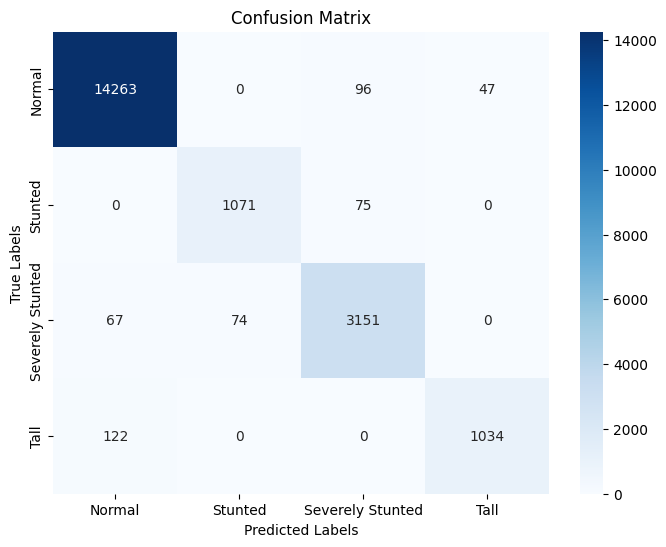

In [20]:
class_labels = ["Normal", "Stunted", "Severely Stunted", "Tall"]

cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [21]:
from google.colab import files

model.save('fnn.h5')
files.download('fnn.h5')